In [1]:
import pandas as  pd
import numpy as np

import datetime
import shap
import eli5
import seaborn as sns
import matplotlib.pyplot as plt

from mvtpy import mvtest
from wordcloud import WordCloud
from scipy import stats
from eli5.sklearn import PermutationImportance
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

from typing import *
import warnings 
warnings.filterwarnings('ignore')

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
Using TensorFlow backend.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will

In [2]:
# 为方面后面操作，设置全局index变量

labels = ['total_purchase_amt','total_redeem_amt']
date_indexs = ['week','year','month','weekday','day']

# 特征提取

## 一、基于日期的静态特征

### 1.1 提取 is 特征

In [3]:
# Load the balance data
def load_data(path: str = 'user_balance_table.csv')->pd.DataFrame:
    data_balance = pd.read_csv(path)
    return data_balance.reset_index(drop=True)
    

# add tiemstamp to dataset
def add_timestamp(data: pd.DataFrame, time_index: str = 'report_date')->pd.DataFrame:
    data_balance = data.copy()
    data_balance['date'] = pd.to_datetime(data_balance[time_index], format= "%Y%m%d")
    data_balance['day'] = data_balance['date'].dt.day
    data_balance['month'] = data_balance['date'].dt.month
    data_balance['year'] = data_balance['date'].dt.year
    data_balance['week'] = data_balance['date'].dt.week
    data_balance['weekday'] = data_balance['date'].dt.weekday
    return data_balance.reset_index(drop=True)

# total amount
def get_total_balance(data: pd.DataFrame, date: str = '2014-03-31')->pd.DataFrame:
    df_tmp = data.copy()
    df_tmp = df_tmp.groupby(['date'])['total_purchase_amt','total_redeem_amt'].sum()
    df_tmp.reset_index(inplace=True)
    return df_tmp[(df_tmp['date']>= date)].reset_index(drop=True)

# Generate the test data
def generate_test_data(data: pd.DataFrame)->pd.DataFrame:
    total_balance = data.copy()
    start = datetime.datetime(2014,9,1)
    testdata = []
    while start != datetime.datetime(2014,10,15):
        temp = [start, np.nan, np.nan]
        testdata.append(temp)
        start += datetime.timedelta(days = 1)
    testdata = pd.DataFrame(testdata)
    testdata.columns = total_balance.columns

    total_balance = pd.concat([total_balance, testdata], axis = 0)
    total_balance = total_balance.reset_index(drop=True)
    return total_balance.reset_index(drop=True)

# Load user's information
def load_user_information(path: str = 'user_profile_table.csv')->pd.DataFrame:
    return pd.read_csv(path)

In [4]:
# 读取数据集

balance_data = load_data('C:/Users/11512/Desktop/datawhale/Purchase Redemption Data/user_balance_table.csv')
balance_data = add_timestamp(balance_data, time_index='report_date')
total_balance = get_total_balance(balance_data)
total_balance = generate_test_data(total_balance)
total_balance = add_timestamp(total_balance, 'date')
user_information = load_user_information('C:/Users/11512/Desktop/datawhale/Purchase Redemption Data/user_profile_table.csv')

In [5]:
total_balance

,date,total_purchase_amt,total_redeem_amt,day,month,year,week,weekday
0,2014-03-31,398884905.0,423852634.0,31,3,2014,14,0
1,2014-04-01,453320585.0,277429358.0,1,4,2014,14,1
2,2014-04-02,355347118.0,272612066.0,2,4,2014,14,2
3,2014-04-03,363877120.0,266605457.0,3,4,2014,14,3
4,2014-04-04,251895894.0,200192637.0,4,4,2014,14,4
...,...,...,...,...,...,...,...,...
193,2014-10-10,NaN,NaN,10,10,2014,41,4
194,2014-10-11,NaN,NaN,11,10,2014,41,5
195,2014-10-12,NaN,NaN,12,10,2014,41,6
196,2014-10-13,NaN,NaN,13,10,2014,42,0


In [6]:
# 获取节假日集合

def get_holiday_set()->Set[datetime.datetime]:
    holiday_set = set()
    # 清明节
    holiday_set = holiday_set | {datetime.datetime(2014,4,5), datetime.datetime(2014,4,6), datetime.datetime(2014,4,7)}
    # 劳动节
    holiday_set = holiday_set | {datetime.datetime(2014,5,1), datetime.datetime(2014,5,2), datetime.datetime(2014,5,3)}
    # 端午节
    holiday_set = holiday_set | {datetime.datetime(2014,5,31), datetime.datetime(2014,6,1), datetime.datetime(2014,6,2)}
    # 中秋节
    holiday_set = holiday_set | {datetime.datetime(2014,9,6), datetime.datetime(2014,9,7), datetime.datetime(2014,9,8)}
    # 国庆节
    holiday_set = holiday_set | {datetime.datetime(2014,10,1), datetime.datetime(2014,10,2), datetime.datetime(2014,10,3),\
                                 datetime.datetime(2014,10,4), datetime.datetime(2014,10,5), datetime.datetime(2014,10,6),\
                                datetime.datetime(2014,10,7)}
    # 中秋节
    holiday_set = holiday_set | {datetime.datetime(2013,9,19), datetime.datetime(2013,9,20), datetime.datetime(2013,9,21)}
    # 国庆节
    holiday_set = holiday_set | {datetime.datetime(2013,10,1), datetime.datetime(2013,10,2), datetime.datetime(2013,10,3),\
                                 datetime.datetime(2013,10,4), datetime.datetime(2013,10,5), datetime.datetime(2013,10,6),\
                                datetime.datetime(2013,10,7)}
    return holiday_set

In [7]:
# 提取所有 is特征

def extract_is_feature(data: pd.DataFrame)->pd.DataFrame:
    total_balance = data.copy().reset_index(drop=True)
    
    # 是否是Weekend
    total_balance['is_weekend'] = 0
    total_balance.loc[total_balance['weekday'].isin((5,6)), 'is_weekend'] = 1
    # 是否是假期
    total_balance['is_holiday'] = 0
    total_balance.loc[total_balance['date'].isin(get_holiday_set()), 'is_holiday'] = 1
    
    # 是否是节假日的第一天
    last_day_flag = 0
    total_balance['is_firstday_of_holiday'] = 0
    for index, row in total_balance.iterrows():
        if last_day_flag == 0 and row['is_holiday'] == 1:
            total_balance.loc[index, 'is_firstday_of_holiday'] = 1
        last_day_flag = row['is_holiday']

    # 是否是节假日的最后一天
    total_balance['is_lastday_of_holiday'] = 0
    for index, row in total_balance.iterrows():
        if row['is_holiday'] == 1 and total_balance.loc[index+1, 'is_holiday'] == 0:
             total_balance.loc[index, 'is_lastday_of_holiday'] = 1

    # 是否是节假日后的上班第一天
    total_balance['is_firstday_of_work'] = 0
    last_day_flag = 0
    for index, row in total_balance.iterrows():
        if last_day_flag == 1 and row['is_holiday'] == 0:
            total_balance.loc[index, 'is_firstday_of_work'] = 1
        last_day_flag = row['is_lastday_of_holiday']

    # 是否不用上班
    #1：上班；0：不上班
    total_balance['is_work'] = 1
    total_balance.loc[(total_balance['is_holiday'] == 1) | (total_balance['is_weekend'] == 1), 'is_work'] = 0
    special_work_day_set = {datetime.datetime(2014,5,4), datetime.datetime(2014,9,28)}
    total_balance.loc[total_balance['date'].isin(special_work_day_set), 'is_work'] = 1

    # 是否明天要上班
    total_balance['is_gonna_work_tomorrow'] = 0
    for index, row in total_balance.iterrows():
        if index == len(total_balance)-1:
            break
        if row['is_work'] == 0 and total_balance.loc[index+1, 'is_work'] == 1:
             total_balance.loc[index, 'is_gonna_work_tomorrow'] = 1

    # 昨天上班了吗
    total_balance['is_worked_yestday'] = 0
    for index, row in total_balance.iterrows():
        if index <= 1:
            continue
        if total_balance.loc[index-1, 'is_work'] == 1:
             total_balance.loc[index, 'is_worked_yestday'] = 1

    # 是否是放假前一天
    total_balance['is_lastday_of_workday'] = 0
    for index, row in total_balance.iterrows():
        if index == len(total_balance)-1:
            break
        if row['is_holiday'] == 0 and total_balance.loc[index+1, 'is_holiday'] == 1:
             total_balance.loc[index, 'is_lastday_of_workday'] = 1

    # 是否周日要上班
    total_balance['is_work_on_sunday'] = 0
    for index, row in total_balance.iterrows():
        if index == len(total_balance)-1:
            break
        if row['weekday'] == 6 and row['is_work'] == 1:
             total_balance.loc[index, 'is_work_on_sunday'] = 1
                
    # 是否是月初第一天
    total_balance['is_firstday_of_month'] = 0
    total_balance.loc[total_balance['day'] == 1, 'is_firstday_of_month'] = 1

    # 是否是月初第二天
    total_balance['is_secday_of_month'] = 0
    total_balance.loc[total_balance['day'] == 2, 'is_secday_of_month'] = 1

    # 是否是月初
    total_balance['is_premonth'] = 0
    total_balance.loc[total_balance['day'] <= 10, 'is_premonth'] = 1

    # 是否是月中
    total_balance['is_midmonth'] = 0
    total_balance.loc[(10 < total_balance['day']) & (total_balance['day'] <= 20), 'is_midmonth'] = 1

    # 是否是月末
    total_balance['is_tailmonth'] = 0
    total_balance.loc[20 < total_balance['day'], 'is_tailmonth'] = 1

    # 是否是每个月第一个周
    total_balance['is_first_week'] = 0
    total_balance.loc[total_balance['week'] % 4 == 1, 'is_first_week'] = 1

    # 是否是每个月第一个周
    total_balance['is_second_week'] = 0
    total_balance.loc[total_balance['week'] % 4 == 2, 'is_second_week'] = 1

    # 是否是每个月第一个周
    total_balance['is_third_week'] = 0
    total_balance.loc[total_balance['week'] % 4 == 3, 'is_third_week'] = 1

    # 是否是每个月第四个周
    total_balance['is_fourth_week'] = 0
    total_balance.loc[total_balance['week'] % 4 == 0, 'is_fourth_week'] = 1
    
    return total_balance.reset_index(drop=True)

In [8]:
# 提取is特征到数据集

total_balance = extract_is_feature(total_balance)

In [9]:
# 编码翌日特征

def encode_data(data: pd.DataFrame, feature_name:str = 'weekday', encoder=OneHotEncoder())->pd.DataFrame():
    total_balance = data.copy()
    week_feature = encoder.fit_transform(np.array(total_balance[feature_name]).reshape(-1, 1)).toarray()
    week_feature = pd.DataFrame(week_feature,columns= [feature_name + '_onehot_'+ str(x) for x in range(len(week_feature[0]))])
    #featureWeekday = pd.concat([total_balance, week_feature], axis = 1).drop(feature_name, axis=1)
    featureWeekday = pd.concat([total_balance, week_feature], axis = 1)
    return featureWeekday

In [10]:
# 编码翌日特征到数据集
#将周几进行onehot编码
total_balance = encode_data(total_balance)

In [11]:
#生成is特征集合

feature = total_balance[[x for x in total_balance.columns if x not in date_indexs]]

### 1.2 is特征的下标签分布分析

In [12]:
# 绘制箱型图

#date_indexs:['week', 'year', 'month', 'weekday', 'day']
#labels:['total_purchase_amt', 'total_redeem_amt']

def draw_boxplot(data: pd.DataFrame)->None:
    f, axes = plt.subplots(7, 4, figsize=(18, 24))
    global date_indexs, labels
    count = 0
    for i in [x for x in data.columns if x not in date_indexs + labels + ['date']]:
        sns.boxenplot(x=i, y='total_purchase_amt', data=data, ax=axes[count // 4][count % 4])
        count += 1

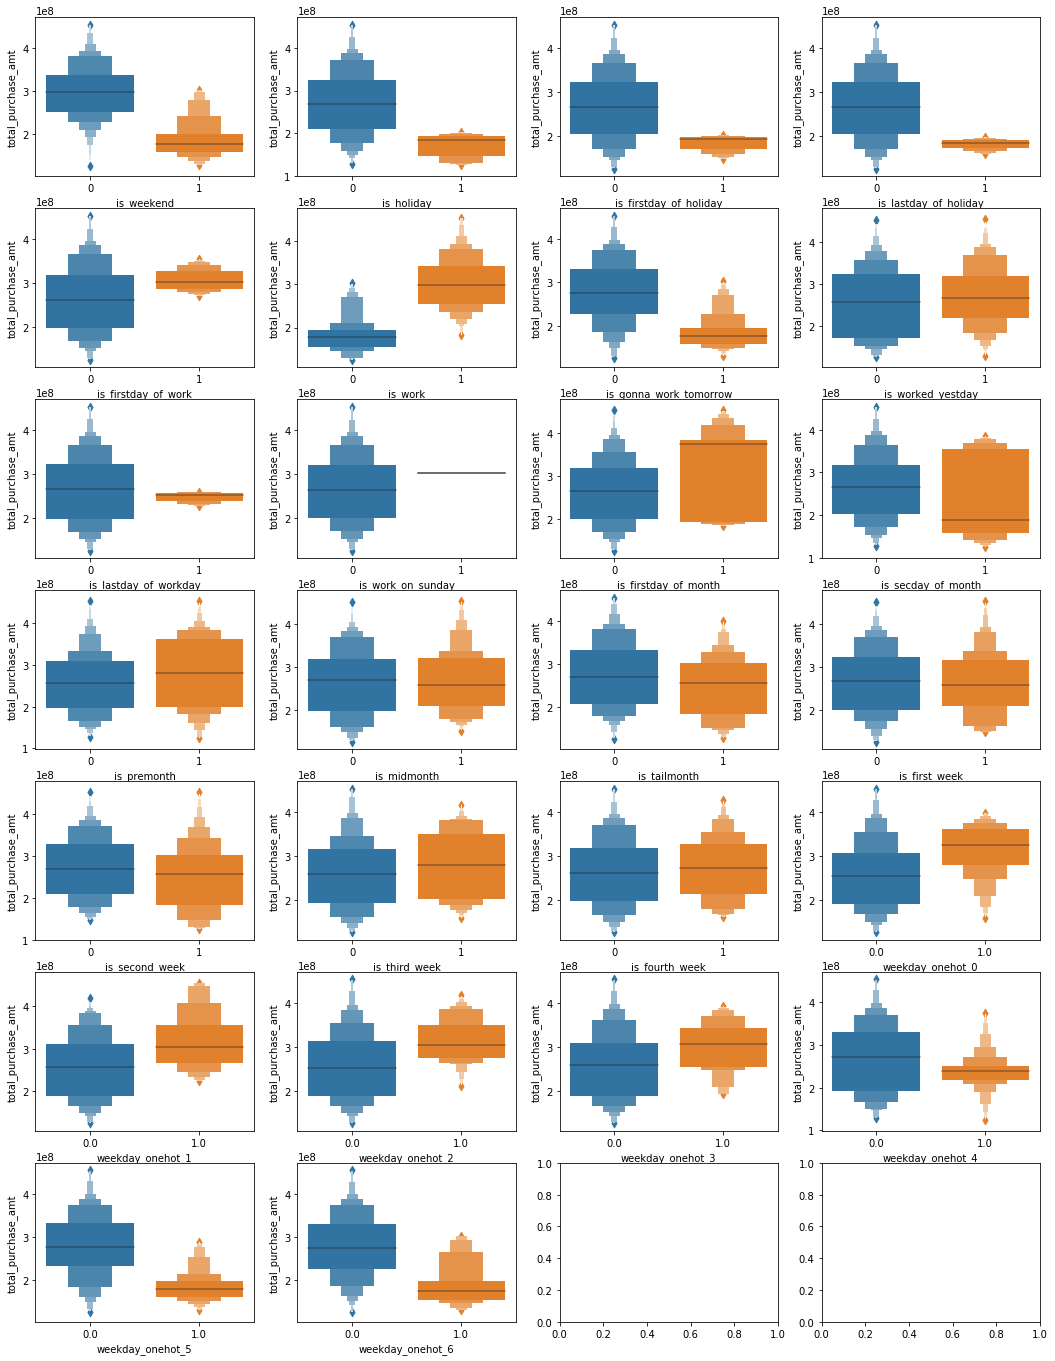

In [13]:
draw_boxplot(feature)

In [96]:
## 剔除看起来较差的特征

purchase_feature_seems_useless += [
      #样本量太少，建模时无效；但若确定这是一个有用规则，可以对结果做修正
      'is_work_on_sunday',
      #中位数差异不明显
      'is_first_week'
]

### 1.3 IS 特征的相关性分析

In [15]:
# 画相关性热力图

def draw_correlation_heatmap(data: pd.DataFrame, way:str = 'pearson')->None:
    feature = data.copy()
    plt.figure(figsize=(20,10))
    plt.title('The ' + way +' coleration between total purchase and each feature')
    sns.heatmap(feature[[x for x in feature.columns if x not in ['total_redeem_amt', 'date'] ]].corr(way),linecolor='white',
        linewidths=0.1,
        cmap="RdBu")

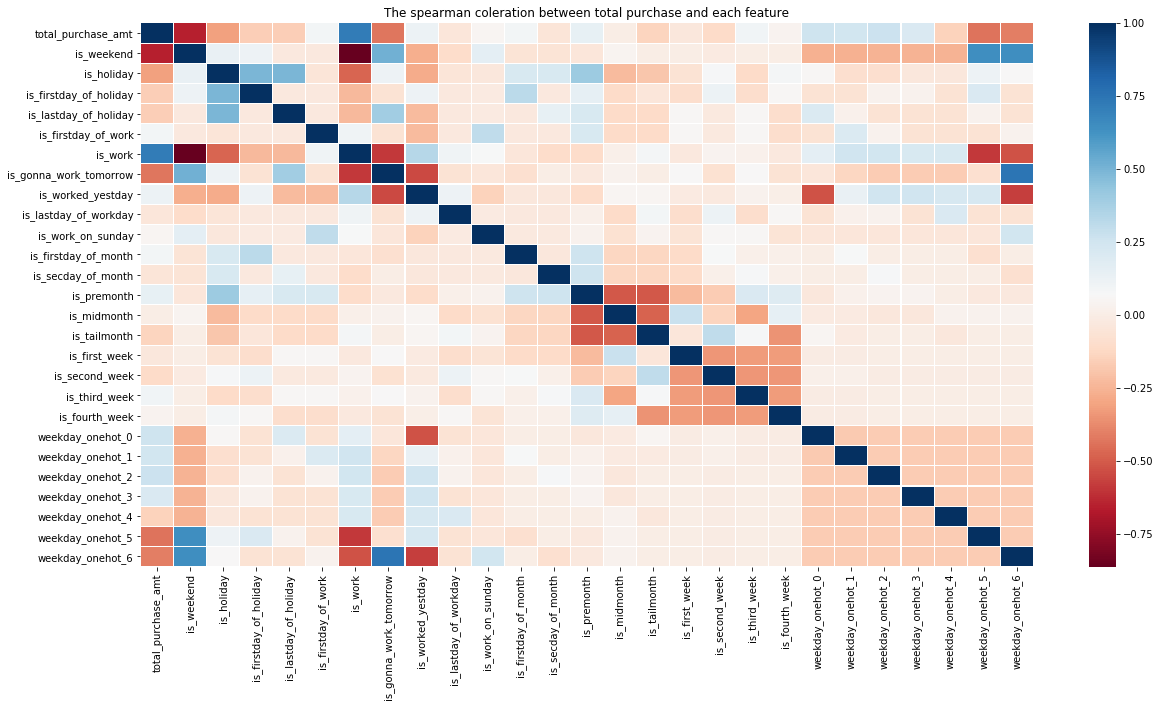

In [16]:
draw_correlation_heatmap(feature, 'spearman')

In [17]:

# 剔除相关性较低的特征

temp = np.abs(feature[[x for x in feature.columns 
                       if x not in ['total_redeem_amt', 'date'] ]].corr('spearman')['total_purchase_amt'])
feature_low_correlation = list(set(temp[temp < 0.1].index))

In [18]:
feature_low_correlation

#['is_secday_of_month', 'is_work_on_sunday', 'is_first_week', 'is_firstday_of_work', 
# 'is_midmonth', 'is_lastday_of_workday', 'is_firstday_of_month', 'is_fourth_week']

['is_firstday_of_month',
 'is_work_on_sunday',
 'is_lastday_of_workday',
 'is_first_week',
 'is_fourth_week',
 'is_firstday_of_work',
 'is_midmonth',
 'is_secday_of_month']

## 二、基于距离的特征

### 2.1 距离特征提取

In [19]:
# 提取距离特征

def extract_distance_feature(data: pd.DataFrame)->pd.DataFrame:
    total_balance = data.copy()
    
    # 距离放假还有多少天
    total_balance['dis_to_nowork'] = 0
    for index, row in total_balance.iterrows():
        #如果今天不上班
        if row['is_work'] == 0:
            step = 1
            flag = 1
            while flag:
                if index - step >= 0 and total_balance.loc[index - step, 'is_work'] == 1:
                    total_balance.loc[index - step, 'dis_to_nowork'] = step
                    step += 1
                else:
                    flag = 0

    #上了多少天班了
    total_balance['dis_from_nowork'] = 0
    step = 0
    for index, row in total_balance.iterrows():
        step += 1
        if row['is_work'] == 1:
            total_balance.loc[index, 'dis_from_nowork'] = step
        else:
            step = 0

    # 距离上班还有多少天
    total_balance['dis_to_work'] = 0
    for index, row in total_balance.iterrows():
        if row['is_work'] == 1:
            step = 1
            flag = 1
            while flag:
                if index - step >= 0 and total_balance.loc[index - step, 'is_work'] == 0:
                    total_balance.loc[index - step, 'dis_to_work'] = step
                    step += 1
                else:
                    flag = 0

    #放了几天假
    total_balance['dis_from_work'] = 0
    step = 0
    for index, row in total_balance.iterrows():
        step += 1
        if row['is_work'] == 0:
            total_balance.loc[index, 'dis_from_work'] = step
        else:
            step = 0


    # 距离节假日还有多少天
    total_balance['dis_to_holiday'] = 0
    for index, row in total_balance.iterrows():
        if row['is_holiday'] == 1:
            step = 1
            flag = 1
            while flag:
                if index - step >= 0 and total_balance.loc[index - step, 'is_holiday'] == 0:
                    total_balance.loc[index - step, 'dis_to_holiday'] = step
                    step += 1
                else:
                    flag = 0

    #在节假日期间休息的第几天
    total_balance['dis_from_holiday'] = 0
    step = 0
    for index, row in total_balance.iterrows():
        step += 1
        if row['is_holiday'] == 0:
            total_balance.loc[index, 'dis_from_holiday'] = step
        else:
            step = 0

    # 距离节假日最后一天还有多少天
    total_balance['dis_to_holiendday'] = 0
    for index, row in total_balance.iterrows():
        if row['is_lastday_of_holiday'] == 1:
            step = 1
            flag = 1
            while flag:
                if index - step >= 0 and total_balance.loc[index - step, 'is_lastday_of_holiday'] == 0:
                    total_balance.loc[index - step, 'dis_to_holiendday'] = step
                    step += 1
                else:
                    flag = 0

    total_balance['dis_from_holiendday'] = 0
    step = 0
    for index, row in total_balance.iterrows():
        step += 1
        if row['is_lastday_of_holiday'] == 0:
            total_balance.loc[index, 'dis_from_holiendday'] = step
        else:
            step = 0

    # 距离月初第几天
    total_balance['dis_from_startofmonth'] = np.abs(total_balance['day'])

    # 距离月的中心点有几天
    total_balance['dis_from_middleofmonth'] = np.abs(total_balance['day'] - 15)

    # 距离星期的中心有几天
    total_balance['dis_from_middleofweek'] = np.abs(total_balance['weekday'] - 3)

    # 距离星期日有几天
    total_balance['dis_from_endofweek'] = np.abs(total_balance['weekday'] - 6)

    return total_balance

In [20]:
# 拼接距离特征到原数据集

total_balance = extract_distance_feature(total_balance)

### 2.2 距离特征分析

In [21]:
# 获取距离特征的列名

feature = total_balance[[x for x in total_balance.columns if x not in date_indexs]]
dis_feature_indexs = [x for x in feature.columns if (x not in date_indexs + labels + ['date']) & ('dis' in x)]

In [22]:
# 画点线

def draw_point_feature(data: pd.DataFrame)->None:
    feature = data.copy()
    f, axes = plt.subplots(data.shape[1] // 3, 3, figsize=(30, data.shape[1] // 3 * 4))
    count = 0
    for i in [x for x in feature.columns if (x not in date_indexs + labels + ['date'])]:
        sns.pointplot(x=i, y="total_purchase_amt",
                markers=["^", "o"], linestyles=["-", "--"],
                kind="point", data=feature, ax=axes[count // 3][count % 3] if data.shape[1] > 3 else axes[count])
        count += 1

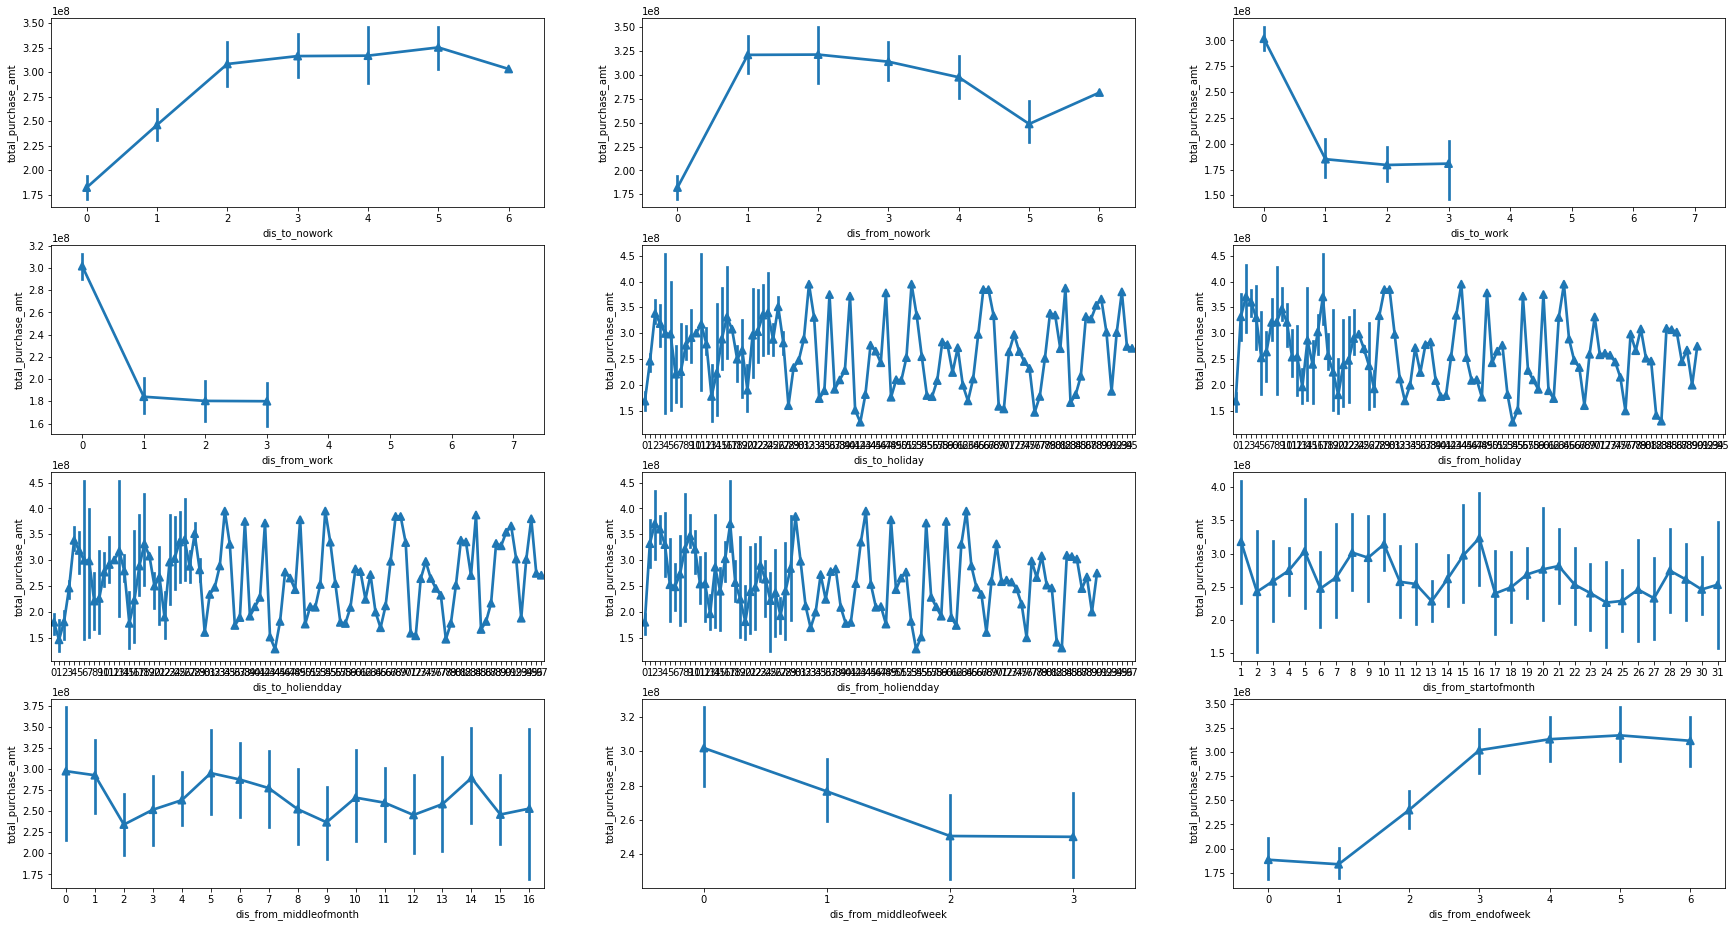

In [23]:
draw_point_feature(feature[['total_purchase_amt'] + dis_feature_indexs])

In [95]:
## 剔除看起来用处不大的特征
purchase_feature_seems_useless += [
                                  #即使做了处理，但方差太大，不可信，规律不明显
                                  'dis_to_holiday',
                                  #方差太大，不可信
                                  'dis_from_startofmonth',
                                  #方差太大，不可信
                                  'dis_from_middleofmonth'
]

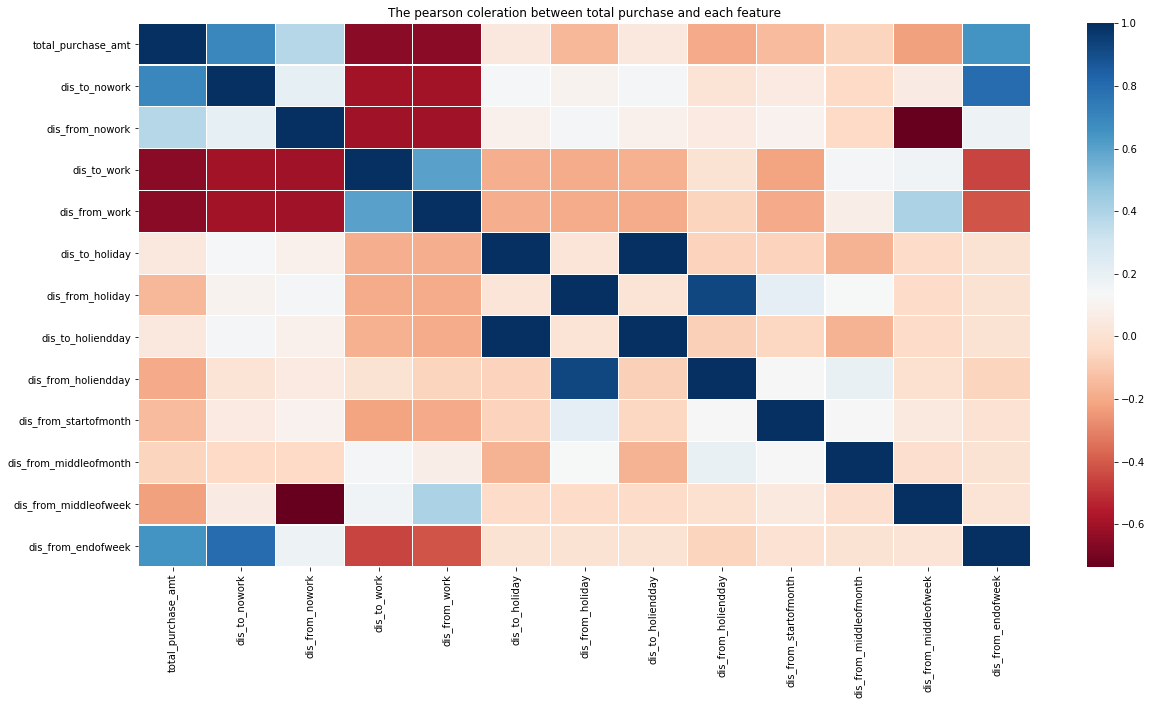

In [81]:

# 画出相关性图

draw_correlation_heatmap(feature[['total_purchase_amt'] + dis_feature_indexs])

In [82]:
# 剔除相关性较差的特征

temp = np.abs(feature[[x for x in feature.columns 
                       if ('dis' in x) | (x in ['total_purchase_amt']) ]].corr()['total_purchase_amt'])
feature_low_correlation += list(set(temp[temp < 0.1].index) )

In [83]:
list(set(temp[temp < 0.1].index) )

['dis_to_holiday', 'dis_from_middleofmonth', 'dis_to_holiendday']

## 三、波峰波谷特征


### 3.1 提取波峰特征

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


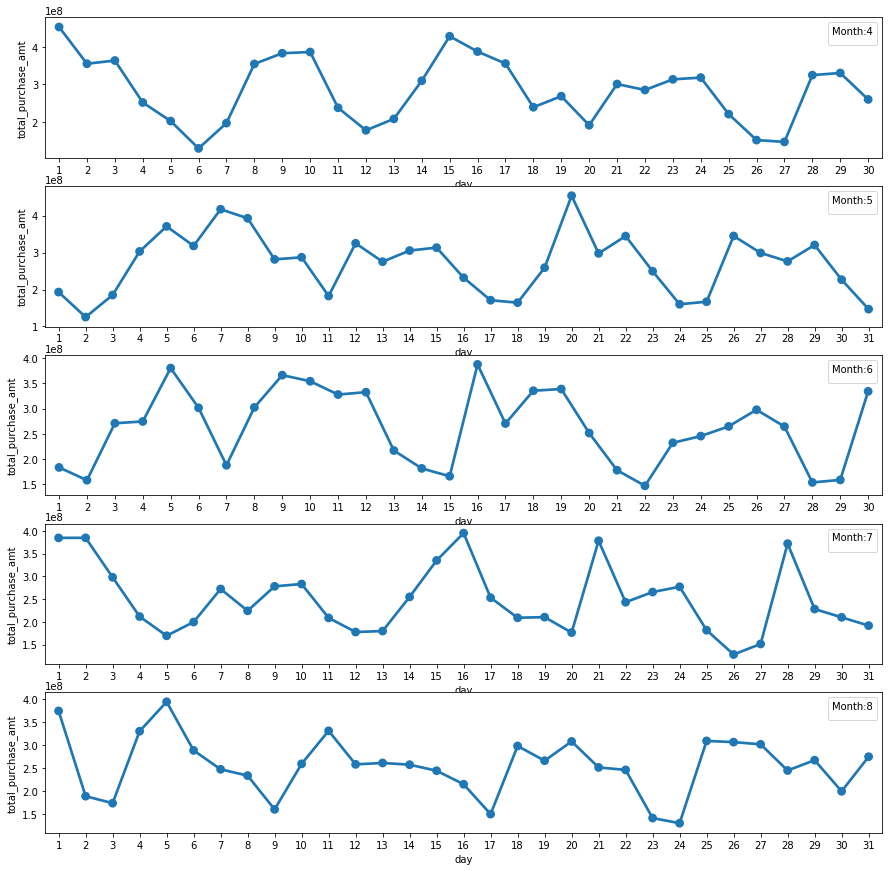

In [32]:
# 观察波峰特点

fig = plt.figure(figsize=(15,15))
for i in range(4,9):
    plt.subplot(5,1,i - 3)
    total_balance_2 = total_balance[(total_balance['date'] >= datetime.datetime(2014,i,1)) & (total_balance['date'] < datetime.datetime(2014,i+1,1))]
    sns.pointplot(x=total_balance_2['day'],y=total_balance_2['total_purchase_amt'])
    plt.legend().set_title('Month:' + str(i))

In [ ]:
#Purchase

#0401(周二)                                     0406（周日，清明节第二天）
#0410(周四，与周二近似)                         0412（周六，与周日近似）
#0415（周二）                                   0420（周日）
#0424（周四，与周二在近似水平）                 0427（周日）
#0429（周二）                                   0502（周五，劳动节第二天）
#0507（周三，与周二差异较大，可能受劳务节影响） 0511（周日）
#0512（周一，与周二有一定差距）                 0518（周日）
#0519（周二）                                   0525（周日）
#0526（周一，与周二有一定差距）                 0531（周六，月末）
#0605（周四，与周二差异大，可能受端午节影响）   0607（周六，可能受端午节影响）
#0609（周一，与周二近似）                       0615（周日）
#0616（周一，与周二差异大）                     0622（周日）
#0626（周四，与周二差异不大）                   0629（周日）
#0701（周二）                                   0705（周六，与周日差距不大）
#0707（周一，与周二有差距）                     0713（周日）
#0716（周三，与周二有一定差距）                 0720（周日）
#0721（周一，与周二有明显差距）                 0726（周六，与周日近似）
#0728（周一，与周二有明显差距）                 0803（周日）
#0805（周二）                                   0809（周六，与周日有较大差距）
#0811（周一，有周二有较大差距）                 0817（周日）
#0818（周一，与周二差距不大）                   0824（周日）

In [33]:
# 设定波峰日期

def extract_peak_feature(data: pd.DataFrame)->pd.DataFrame:
    total_balance = data.copy()
    # 距离purchase波峰（即周二）有几天
    total_balance['dis_from_purchase_peak'] = np.abs(total_balance['weekday'] - 1)

    # 距离purchase波谷（即周日）有几天，与dis_from_endofweek相同
    total_balance['dis_from_purchase_valley'] = np.abs(total_balance['weekday'] - 6)
    
    return total_balance

In [34]:
# 提取波峰特征

total_balance = extract_peak_feature(total_balance)
feature = total_balance[[x for x in total_balance.columns if x not in date_indexs]]

### 3.2 分析波峰特征

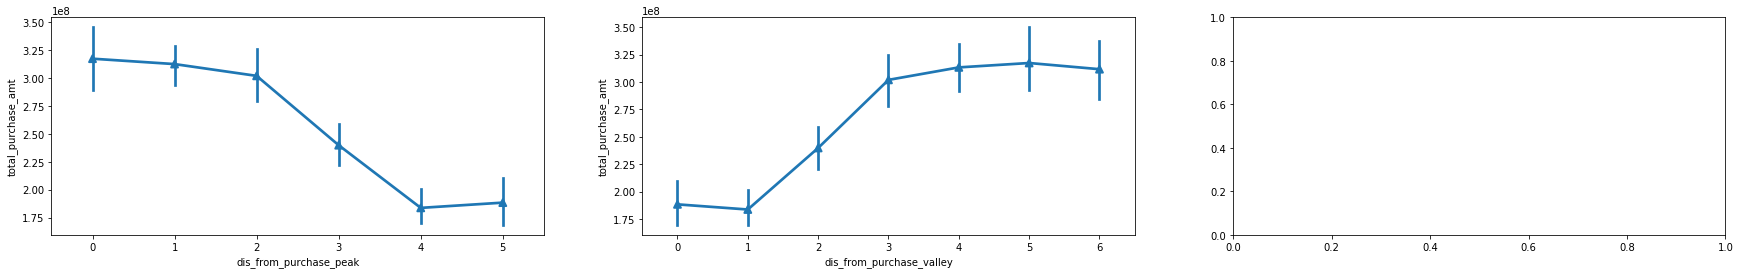

In [35]:
draw_point_feature(feature[['total_purchase_amt'] + ['dis_from_purchase_peak','dis_from_purchase_valley']])

In [36]:
temp = np.abs(feature[[x for x in feature.columns if ('peak' in x) or ('valley' in x) or (x in ['total_purchase_amt']) ]].corr()['total_purchase_amt'])

In [45]:
temp 

total_purchase_amt          1.000000
dis_from_purchase_peak      0.682149
dis_from_purchase_valley    0.653811
Name: total_purchase_amt, dtype: float64

## 四、加入周期因子作为特征

### 4.1 提取周期因子

In [38]:
def generate_rate(df, month_index):
    total_balance = df.copy()
    pure_balance = total_balance[['date','total_purchase_amt','total_redeem_amt']]
    pure_balance = pure_balance[(pure_balance['date'] >= datetime.datetime(2014,3,1)) & (pure_balance['date'] < datetime.datetime(2014, month_index, 1))]
    pure_balance['weekday'] = pure_balance['date'].dt.weekday
    pure_balance['day'] = pure_balance['date'].dt.day
    pure_balance['week'] = pure_balance['date'].dt.week
    pure_balance['month'] = pure_balance['date'].dt.month
    weekday_rate = pure_balance[['weekday']+labels].groupby('weekday',as_index=False).mean()
    for name in labels:
        weekday_rate = weekday_rate.rename(columns={name: name+'_weekdaymean'})
    weekday_rate['total_purchase_amt_weekdaymean'] /= np.mean(pure_balance['total_purchase_amt'])
    weekday_rate['total_redeem_amt_weekdaymean'] /= np.mean(pure_balance['total_redeem_amt'])
    pure_balance = pd.merge(pure_balance, weekday_rate, on='weekday', how='left')
    weekday_count = pure_balance[['day','weekday','date']].groupby(['day','weekday'],as_index=False).count()
    weekday_count = pd.merge(weekday_count, weekday_rate, on = 'weekday')
    weekday_count['total_purchase_amt_weekdaymean'] *= weekday_count['date'] / (len(set(pure_balance['month'])) - 1)
    weekday_count['total_redeem_amt_weekdaymean'] *= weekday_count['date'] / (len(set(pure_balance['month'])) - 1)
    day_rate = weekday_count.drop(['weekday','date'],axis=1).groupby('day',as_index=False).sum()
    weekday_rate.columns = ['weekday','purchase_weekdayrate','redeem_weekdayrate']
    day_rate.columns = ['day','purchase_dayrate','redeem_dayrate']
    day_rate['date'] = datetime.datetime(2014, month_index, 1)
    for index, row in day_rate.iterrows():
        if month_index in (2,4,6,9) and row['day'] == 31:
            continue
        day_rate.loc[index, 'date'] = datetime.datetime(2014, month_index, int(row['day']))
    day_rate['weekday'] = day_rate['date'].dt.weekday
    day_rate = pd.merge(day_rate, weekday_rate, on='weekday')
    day_rate['purchase_dayrate'] = day_rate['purchase_weekdayrate'] / day_rate['purchase_dayrate']
    day_rate['redeem_dayrate'] = day_rate['redeem_weekdayrate'] / day_rate['redeem_dayrate']
    weekday_rate['month'] = month_index
    day_rate['month'] = month_index
    
    return weekday_rate, day_rate[['day','purchase_dayrate','redeem_dayrate','month']].sort_values('day')

In [39]:
# 生成周期因子并合并到数据集

weekday_rate_list = []
day_rate_list = []
for i in range(3, 10):
    weekday_rate, day_rate = generate_rate(total_balance, i)
    weekday_rate_list.append(weekday_rate.reset_index(drop=True))
    day_rate_list.append(day_rate.reset_index(drop=True))

weekday_rate_list = pd.concat(weekday_rate_list).reset_index(drop=True)
day_rate_list = pd.concat(day_rate_list).reset_index(drop=True)
total_balance = pd.merge(total_balance, weekday_rate_list, on=['weekday','month'], how='left')
total_balance = pd.merge(total_balance, day_rate_list, on=['day','month'], how='left')

In [40]:
# 对周期因子进行特殊处理

for i in [x for x in total_balance.columns 
          if 'rate' in x and x not in labels + date_indexs]:
    total_balance[i] = total_balance[i].fillna(np.nanmedian(total_balance[i]))


### 4.2 分析周期因子的相关性

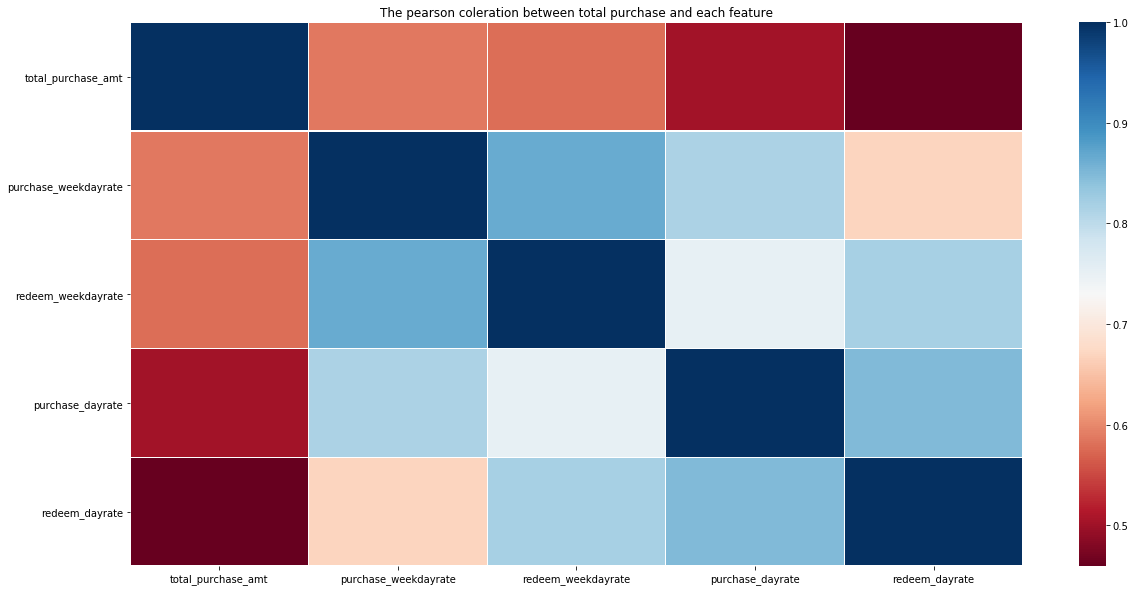

In [43]:
#画出相关性图

draw_correlation_heatmap(total_balance[['total_purchase_amt'] 
                                       + [x for x in total_balance.columns 
                                          if 'rate' in x and x not in labels + date_indexs]])

In [44]:
# 剔除相关性低的特征

feature = total_balance.drop(date_indexs, axis=1)

In [49]:
total_balance[date_indexs]

,week,year,month,weekday,day
0,14,2014,3,0,31
1,14,2014,4,1,1
2,14,2014,4,2,2
3,14,2014,4,3,3
4,14,2014,4,4,4
...,...,...,...,...,...
193,41,2014,10,4,10
194,41,2014,10,5,11
195,41,2014,10,6,12
196,42,2014,10,0,13


## 五、加入动态时序特征

### 5.1 提取动态特征

In [52]:
## 提取动态特征

def get_amtfeature_with_time(data: pd.DataFrame)->pd.DataFrame:
    df_tmp_ = data[labels + date_indexs + ['date']].copy()
    total_balance = data.copy()
    
    df_tmp_ = df_tmp_[(df_tmp_['date']>=datetime.datetime(2014,3,3))]
    df_tmp_['weekday'] = df_tmp_['date'].dt.weekday + 1
    df_tmp_['week'] = df_tmp_['date'].dt.week - min(df_tmp_['date'].dt.week) + 1
    df_tmp_['day'] = df_tmp_['date'].dt.day
    df_tmp_['month'] = df_tmp_['date'].dt.month
    df_tmp_.reset_index(inplace=True)
    del df_tmp_['index']
    df_purchase = pd.DataFrame(columns = ['weekday1','weekday2','weekday3','weekday4',
                                          'weekday5','weekday6','weekday7'])
    count = 0

    for i in range(len(df_tmp_)):
        df_purchase.loc[count,'weekday'+str(df_tmp_.loc[i,'weekday'])] = df_tmp_.loc[i,'total_purchase_amt']
        if df_tmp_.loc[i,'weekday'] == 7:
            count = count + 1

    df_tmp_['purchase_weekday_median'] = np.nan
    df_tmp_['purchase_weekday_mean'] = np.nan
    df_tmp_['purchase_weekday_min'] = np.nan
    df_tmp_['purchase_weekday_max'] = np.nan
    df_tmp_['purchase_weekday_std'] = np.nan
    df_tmp_['purchase_weekday_skew'] = np.nan

    for i in range(len(df_tmp_)):
        #从2014年3月31日开始统计
        if i > 4*7-1:
            df_tmp_.loc[i,'purchase_weekday_median'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].median()

            df_tmp_.loc[i,'purchase_weekday_mean'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].mean()

            df_tmp_.loc[i,'purchase_weekday_min'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].min()    

            df_tmp_.loc[i,'purchase_weekday_max'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].max()   

            df_tmp_.loc[i,'purchase_weekday_std'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].std() 

            df_tmp_.loc[i,'purchase_weekday_skew'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].skew() 

    colList = ['purchase_weekday_median','purchase_weekday_mean','purchase_weekday_min',
               'purchase_weekday_max','purchase_weekday_std','purchase_weekday_skew']
    total_balance = pd.merge(total_balance, df_tmp_[colList+['day','month']], on=['day','month'], how='left')
    return total_balance

In [53]:
# 合并特征到数据集

total_balance = get_amtfeature_with_time(total_balance)

In [54]:
# 对动态特征做特殊处理

for i in [x for x in total_balance.columns 
          if '_weekday_' in x and x not in labels + date_indexs]:
    total_balance[i] = total_balance[i].fillna(np.nanmedian(total_balance[i]))

### 5.2 分析动态特征相关性

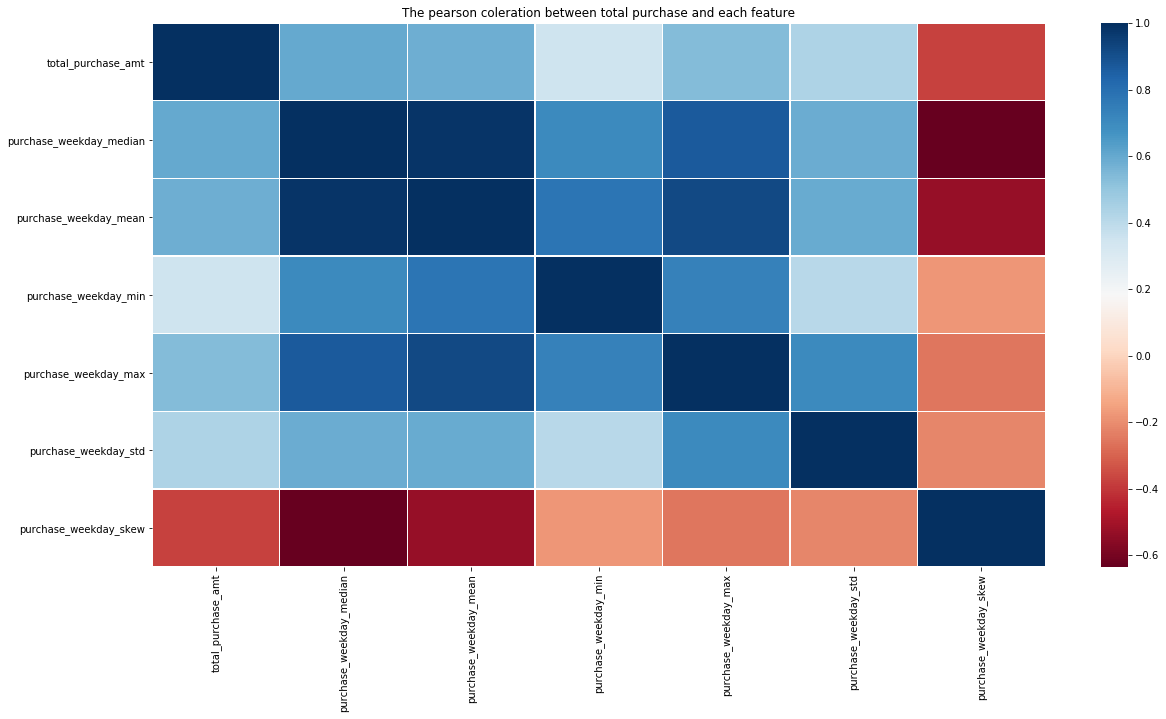

In [56]:
# 绘制动态特征的相关性图

draw_correlation_heatmap(total_balance[['total_purchase_amt'] + 
                                      ['purchase_weekday_median',
                                      'purchase_weekday_mean','purchase_weekday_min',
                                       'purchase_weekday_max','purchase_weekday_std',
                                       'purchase_weekday_skew'
                                      ]])

In [58]:
feature[labels + ['dis_to_nowork', 'dis_to_work', 'dis_from_work', 'purchase_weekdayrate',
       'redeem_dayrate', 'weekday_onehot_5', 'weekday_onehot_6',
       'dis_from_nowork', 'is_holiday', 'weekday_onehot_1', 'weekday_onehot_2',
       'weekday_onehot_0', 'dis_from_middleofweek', 'dis_from_holiendday',
       'weekday_onehot_3', 'is_lastday_of_holiday', 'is_firstday_of_holiday',
       'weekday_onehot_4', 'is_worked_yestday', 'is_second_week',
       'is_third_week', 'dis_from_startofmonth', 'dis_from_holiday', 'total_purchase_amt',
       'total_redeem_amt', 'date']].to_csv('C:/Users/11512/Desktop/datawhale/Feature/0615_residual_purchase_origined.csv', index=False)

# 特征劣汰剔除

### 1.1 剔除无法有效分割数据集的特征

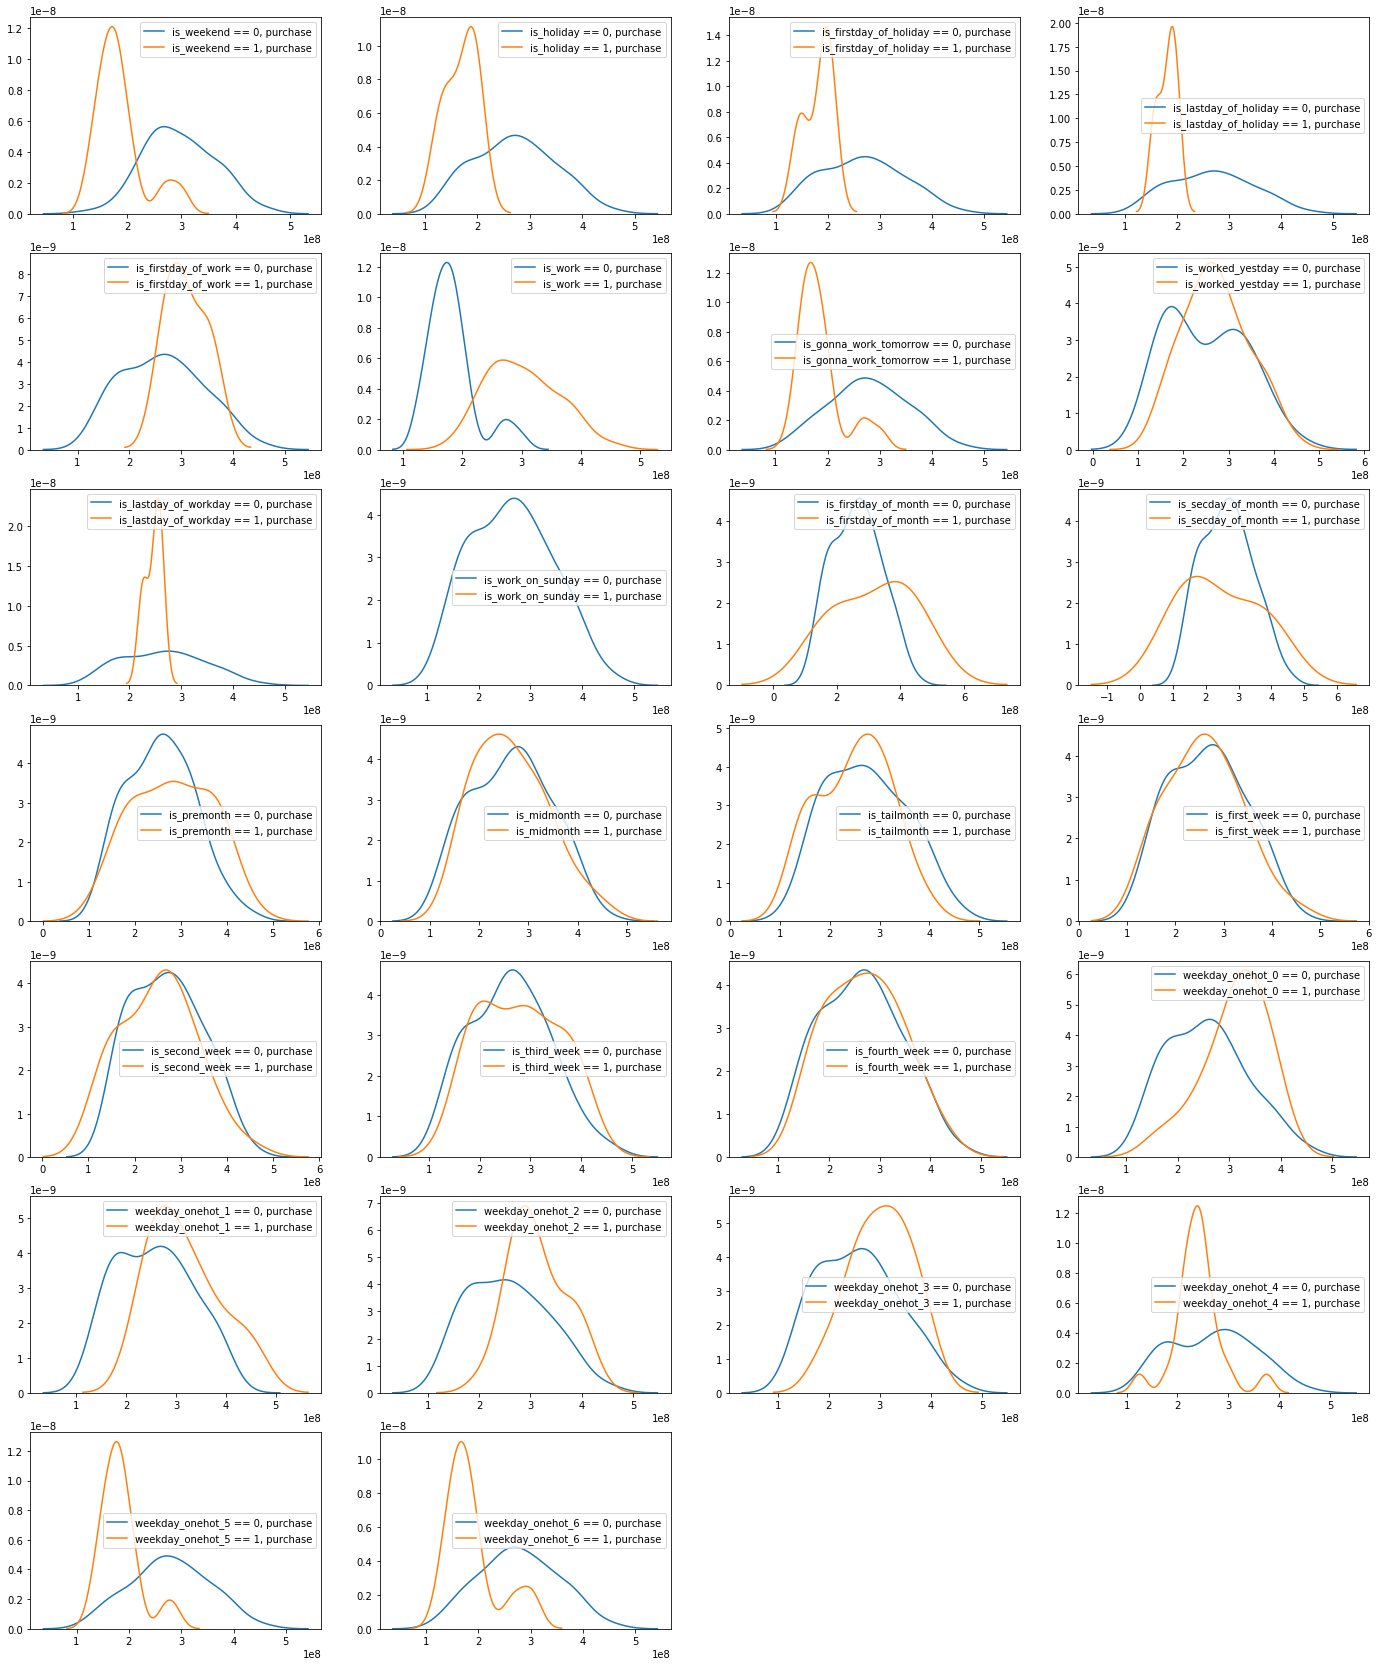

In [59]:
# 画出各个特征分割数据集的分布估计图
plt.figure(figsize=(4 * 6, 6 * len(feature.columns) / 6))
count = 0
for i in [x for x in feature.columns 
          if (x not in labels + date_indexs + ['date']) 
          & ('amt' not in x) & ('dis' not in x) & ('rate' not in x)]:
    count += 1
    if feature[feature[i] == 0].empty:
        continue
    plt.subplot(len(feature.columns) / 4, 4, count)
    
    ax = sns.kdeplot(feature[feature[i] == 0]['total_purchase_amt'], label= str(i) + ' == 0, purchase')
    ax = sns.kdeplot(feature[feature[i] == 1]['total_purchase_amt'], label= str(i) + ' == 1, purchase')

In [94]:
# 剔除对数据集划分不明显的特征
purchase_feature_seems_useless = []
purchase_feature_seems_useless += ['is_first_week','is_fourth_week','is_premonth','is_midmonth','is_tailmonth']

In [97]:
purchase_feature_seems_useless

['is_first_week',
 'is_fourth_week',
 'is_premonth',
 'is_midmonth',
 'is_tailmonth',
 'dis_to_holiday',
 'dis_from_startofmonth',
 'dis_from_middleofmonth',
 'is_work_on_sunday',
 'is_first_week']

### 1.2 使用MVTest挽回一些有依赖性但是不相关的特征

In [98]:
feature_low_correlation

['is_firstday_of_month',
 'is_work_on_sunday',
 'is_lastday_of_workday',
 'is_first_week',
 'is_fourth_week',
 'is_firstday_of_work',
 'is_midmonth',
 'is_secday_of_month',
 'dis_to_holiday',
 'dis_from_middleofmonth',
 'dis_to_holiendday']

In [99]:
# MVtest Ref: https://github.com/ChuanyuXue/MVTest

l = mvtest.mvtest()

name_list = []
Tn_list = []
p_list = []
for i in [i for i in feature_low_correlation if 'is' in i or 'discret' in i]:
    pair = l.test(feature['total_purchase_amt'], feature[i])
    name_list.append(str(i))
    Tn_list.append(pair['Tn'])
    p_list.append(pair['p-value'][0])
temp = pd.DataFrame([name_list,Tn_list]).T.sort_values(1)
temp[1] = np.abs(temp[1])
feature_saved_from_mv_purchase = list(temp.sort_values(1, ascending=False)[temp[1] > 0.5984][0])

In [100]:
feature_saved_from_mv_purchase

['dis_to_holiendday', 'dis_to_holiday', 'dis_from_middleofmonth']

### 1.3 剔除复共线特征

In [101]:
feature = feature[[x for x in feature.columns 
                   if (x not in feature_low_correlation + purchase_feature_seems_useless) or\
                   (x in feature_saved_from_mv_purchase )]]

In [103]:
purchase_cors = feature.corr()
purchase_cors['total_purchase_amt'] = np.abs(purchase_cors['total_purchase_amt'])
feature_lists = list(purchase_cors.sort_values(by='total_purchase_amt',ascending=False).index)[2:]
feature_temp = feature.dropna()

In [104]:
# 这里要注意 保留的时候按照相关性降序排序 剔除按照相关性升序排序的顺序
thershold = 0.8
for i in range(len(feature_lists)):
    for k in range(len(feature_lists)-1, -1, -1):
        if i >= len(feature_lists) or k >= len(feature_lists) or i == k:
            break
        if np.abs(np.corrcoef(feature_temp[feature_lists[i]], feature_temp[feature_lists[k]])[0][1]) > thershold:
            higher_feature_temp = feature_temp[feature_lists[i]] * feature_temp[feature_lists[k]]
            if np.abs(np.corrcoef(feature_temp[feature_lists[i]], higher_feature_temp)[0][1]) <= thershold:
                name = str(feature_lists[i]) + '%%%%' + str(feature_lists[k])
                feature_temp[name] = higher_feature_temp
                feature[name] = feature[feature_lists[i]] * feature[feature_lists[k]]
                feature_lists.append(name)
            feature_temp = feature_temp.drop(feature_lists[k], axis=1)
            feature_lists.remove(feature_lists[k])


In [105]:
feature = feature[[x for x in feature_lists if x not in labels] + labels + ['date']]

In [106]:
feature_lists

['dis_to_nowork',
 'dis_to_work',
 'dis_from_work',
 'purchase_weekdayrate',
 'total_redeem_amt',
 'redeem_dayrate',
 'weekday_onehot_5',
 'weekday_onehot_6',
 'dis_from_nowork',
 'is_holiday',
 'weekday_onehot_1',
 'weekday_onehot_2',
 'weekday_onehot_0',
 'dis_from_middleofweek',
 'dis_from_holiendday',
 'weekday_onehot_3',
 'is_lastday_of_holiday',
 'is_firstday_of_holiday',
 'weekday_onehot_4',
 'is_worked_yestday',
 'is_second_week',
 'is_third_week',
 'dis_from_middleofmonth',
 'dis_to_holiendday',
 'dis_to_nowork%%%%dis_from_purchase_peak']

In [107]:
feature.to_csv('C:/Users/11512/Desktop/datawhale/Feature/purchase_feature_droped_0614.csv',index=False)

## 选出优胜特征

In [110]:
# 分割数据集

def split_data_underline(data):
    trainset = data[(datetime.datetime(2014,4,1) <= data['date']) & (data['date'] < datetime.datetime(2014,8,1))]
    testset = data[(datetime.datetime(2014,8,1) <= data['date']) & (data['date'] < datetime.datetime(2014,9,1))]
    return trainset, testset

### 1.1 使用SHAP包获取优胜特征
SHAP testues represent the fair score of features depending on their contribution towards the total score in the set of features.

SHAP also can visualize how the score changes when the feature testue is low/high on each data.

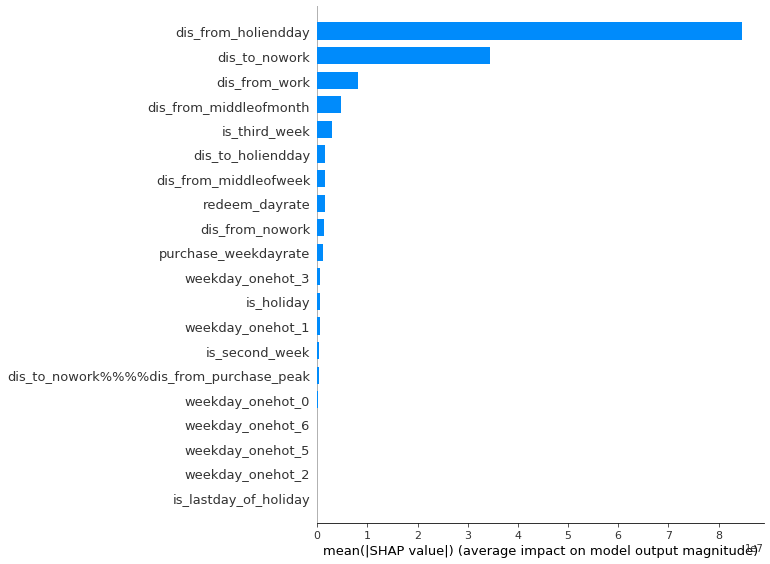

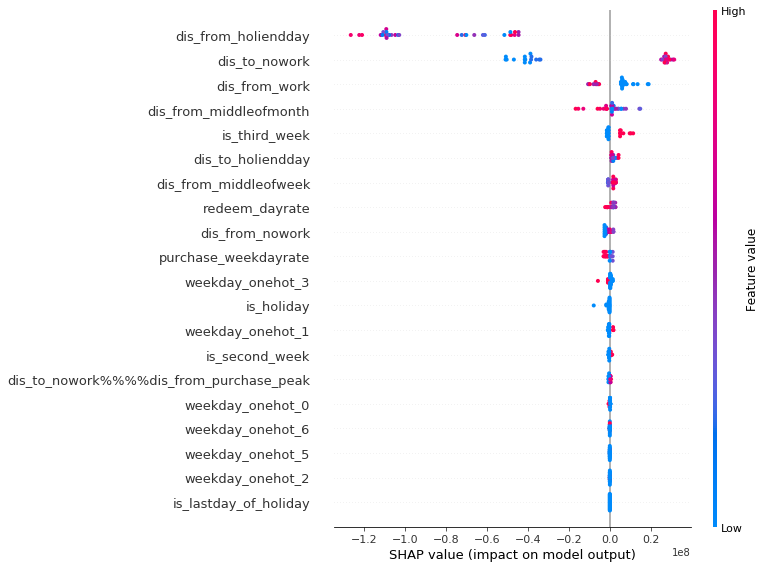

In [111]:
shap.initjs()
from sklearn import tree
model = tree.DecisionTreeRegressor()
train, test = split_data_underline(feature.dropna())
features = [x for x in train.columns if x not in date_indexs]
model.fit(train[features].drop(labels+['date'], axis=1), train['total_purchase_amt'])

explainer = shap.TreeExplainer(model)
shap_testues = explainer.shap_values(test[features].drop(labels+['date'], axis=1))

shap.summary_plot(shap_testues, test[features].drop(labels+['date'], axis=1), plot_type='bar')

shap.summary_plot(shap_testues, test[features].drop(labels+['date'], axis=1))

tree_important_purchase = pd.DataFrame(np.mean(np.abs(shap_testues), axis=0),[x for x in features if x not in labels + date_indexs + ['date']]).reset_index()

In [112]:
tree_important_purchase = tree_important_purchase.sort_values(0, ascending=False).reset_index(drop=True)
tree_important_purchase = list(tree_important_purchase[:20]['index'])

In [113]:
tree_important_purchase

['dis_from_holiendday',
 'dis_to_nowork',
 'dis_from_work',
 'dis_from_middleofmonth',
 'is_third_week',
 'dis_to_holiendday',
 'dis_from_middleofweek',
 'redeem_dayrate',
 'dis_from_nowork',
 'purchase_weekdayrate',
 'weekday_onehot_3',
 'is_holiday',
 'weekday_onehot_1',
 'is_second_week',
 'dis_to_nowork%%%%dis_from_purchase_peak',
 'weekday_onehot_0',
 'weekday_onehot_6',
 'weekday_onehot_5',
 'weekday_onehot_2',
 'is_firstday_of_holiday']

In [114]:
# 输出选择的特征

def draw_cloud(feature_index: List[str])->None:
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    ciyun = WordCloud(background_color='white', max_font_size=40)
    ciyun.generate(text=''.join([x+' ' for x in feature_index if x != 'total_purchase_amt']))
    plt.imshow(ciyun, interpolation='bilinear')
    plt.axis("off")

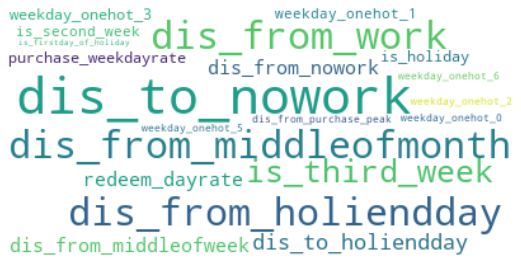

In [115]:
draw_cloud(tree_important_purchase)